# Aprendizaje.

En este Jupiter Notebook se realizaran las pruebas de conexión y adquicisión de datos de EEG con OpenBCI Cyton.

## Introducción

El OpenBCI Cyton es una plataforma de adquisición de bioseñales de código abierto que permite la captura de actividad electroencefalográfica (EEG), electromiográfica (EMG) y electrocardiográfica (ECG). Este tutorial detalla el proceso para configurar el hardware Cyton, instalar las dependencias necesarias y comenzar a adquirir y procesar datos mediante Python.

## Requisitos Previos

- Python 3.7+ instalado
- Conocimientos básicos de programación en Python
- Placa OpenBCI Cyton
- Dongle USB para comunicación inalámbrica

## 1. Preparación del Hardware

### 1.1 Componentes del Sistema Cyton

La placa Cyton incluye:

- Microcontrolador PIC32MX250F128B
- Chip ADS1299 para adquisición de señales biológicas
- Módulo de radio RFDuino para comunicación inalámbrica
- 8 canales de adquisición (ampliables a 16 con el módulo Daisy)
- Conexión micro-USB para programación y alimentación

### 1.2 Conexión Física

1. Inserte el dongle USB en un puerto disponible de su ordenador
2. Encienda la placa Cyton mediante el interruptor de alimentación
3. Verifique que el LED azul del dongle parpadee, indicando comunicación

## 2. Instalación del Software

### 2.1 Instalación de Dependencias

In [4]:
#Creación de un entorno virtual
#python -m venv openbci-env
#source openbci-env/bin/activate  # En Windows: openbci-env\Scripts\activate

# Instalación de dependencias principales
!pip install pyserial
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install brainflow


   ---------------------------------------- 0.0/28.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/28.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/28.6 MB ? eta -:--:--
   - -------------------------------------- 0.8/28.6 MB 1.7 MB/s eta 0:00:17
   - -------------------------------------- 1.0/28.6 MB 1.7 MB/s eta 0:00:16
   -- ------------------------------------- 1.6/28.6 MB 1.8 MB/s eta 0:00:15
   -- ------------------------------------- 1.8/28.6 MB 1.9 MB/s eta 0:00:15
   --- ------------------------------------ 2.4/28.6 MB 1.9 MB/s eta 0:00:14
   ---- ----------------------------------- 2.9/28.6 MB 2.0 MB/s eta 0:00:13
   ----- ---------------------------------- 3.7/28.6 MB 2.2 MB/s eta 0:00:12
   ----- ---------------------------------- 4.2/28.6 MB 2.3 MB/s eta 0:00:11
   ------ --------------------------------- 5.0/28.6 MB 2.5 MB/s eta 0:00:10
   -------- ------------------------------- 5.8/28.6 MB 2.6 MB/s eta 0:00:09
   --------- -------

## 3. Configuración del Puerto Serial

Es necesario identificar el puerto COM al que está conectado el dongle USB:

### 3.1 En Windows

1. Abra el Administrador de Dispositivos
2. Busque "Puertos (COM y LPT)"
3. Identifique el dispositivo "Dongle RFDuino" y anote su puerto COM (ej. COM3)

### 3.2 En Linux/Mac

```bash
ls /dev/tty*
```

Busque un dispositivo como `/dev/ttyUSB0` o similar que haya aparecido al conectar el dongle.

## 4. Prueba de Conexión Básica

Este script verifica la comunicación con la placa Cyton:

In [17]:
# Prueba de conexión con OpenBCI Cyton
# Este script establece una conexión básica con la placa y verifica su funcionamiento

import argparse
import time
import numpy as np
import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

def test_connection(puerto_serial):
    # Configuración de parámetros de conexión
    params = BrainFlowInputParams()
    params.serial_port = puerto_serial  # Reemplazar con tu puerto serial
    
    # Inicialización de la placa (Cyton = 0 en BoardIds)
    board = BoardShim(BoardIds.CYTON_BOARD, params)
    
    try:
        # Habilitamos logs para depuración
        BoardShim.enable_dev_board_logger()
        
        # Conexión con la placa
        board.prepare_session()
        print("Conexión establecida con éxito")
        
        # Iniciar streaming
        board.start_stream()
        print("Streaming iniciado")
        
        # Adquirir datos por 5 segundos
        time.sleep(5)
        
        # Obtener datos
        data = board.get_board_data()
        print(f"Datos adquiridos: {data.shape}")
        
        # Detener streaming
        board.stop_stream()
        board.release_session()
        
        print("Prueba completada con éxito")
        # se cierra la sesión
        
        return True
        
    except Exception as e:
        print(f"Error durante la prueba: {e}")
        return False

test_connection("COM3")

Error durante la prueba: BOARD_NOT_READY_ERROR:7 unable to prepare streaming session


False

## 5. Adquisición de Datos EEG

El siguiente ejemplo muestra cómo adquirir datos EEG y guardarlos en un archivo CSV:

In [32]:
# Adquisición de datos EEG con OpenBCI Cyton
# Este script captura datos EEG durante un período específico y los guarda en formato CSV

import argparse
import time
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations

def adquirir_datos_eeg(puerto_serial, duracion=60, nombre_archivo='datos_eeg.csv'):
    """
    Adquiere datos EEG de la placa Cyton y los guarda en formato CSV
    
    Parámetros:
        puerto_serial (str): Puerto de conexión del dongle
        duracion (int): Duración de la adquisición en segundos
        nombre_archivo (str): Nombre del archivo de salida
    """
    # Configuración de la conexión
    params = BrainFlowInputParams()
    params.serial_port = puerto_serial
    
    # Inicialización de la placa
    board = BoardShim(BoardIds.CYTON_BOARD, params)
    board.prepare_session()
    
    # Frecuencia de muestreo
    fs = BoardShim.get_sampling_rate(BoardIds.CYTON_BOARD)
    print(f"Frecuencia de muestreo: {fs} Hz")
    
    # Iniciar adquisición
    board.start_stream()
    print(f"Adquiriendo datos durante {duracion} segundos...")
    
    time.sleep(duracion)
    
    # Detener adquisición
    data = board.get_board_data()
    board.stop_stream()
    board.release_session()
    
    # Obtener los canales EEG (excluyendo timestamps y otros datos)
    eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD)
    eeg_data = data[eeg_channels]
    
    # Crear DataFrame con los datos
    df = pd.DataFrame(eeg_data.T)
    column_names = [f'Canal_{i+1}' for i in range(len(eeg_channels))]
    df.columns = column_names
    
    # Añadir columna de tiempo
    df['Tiempo'] = np.arange(len(df)) / fs
    
    # Guardar datos
    df.to_csv(nombre_archivo, index=False)
    print(f"Datos guardados en {nombre_archivo}")
    return df

# Ejemplo de uso
adquirir_datos_eeg("COM3", duracion=10, nombre_archivo='datos_eeg.csv')

BrainFlowError: BOARD_NOT_READY_ERROR:7 unable to prepare streaming session

## 6. Visualización en Tiempo Real

Este ejemplo muestra cómo visualizar señales EEG en tiempo real:

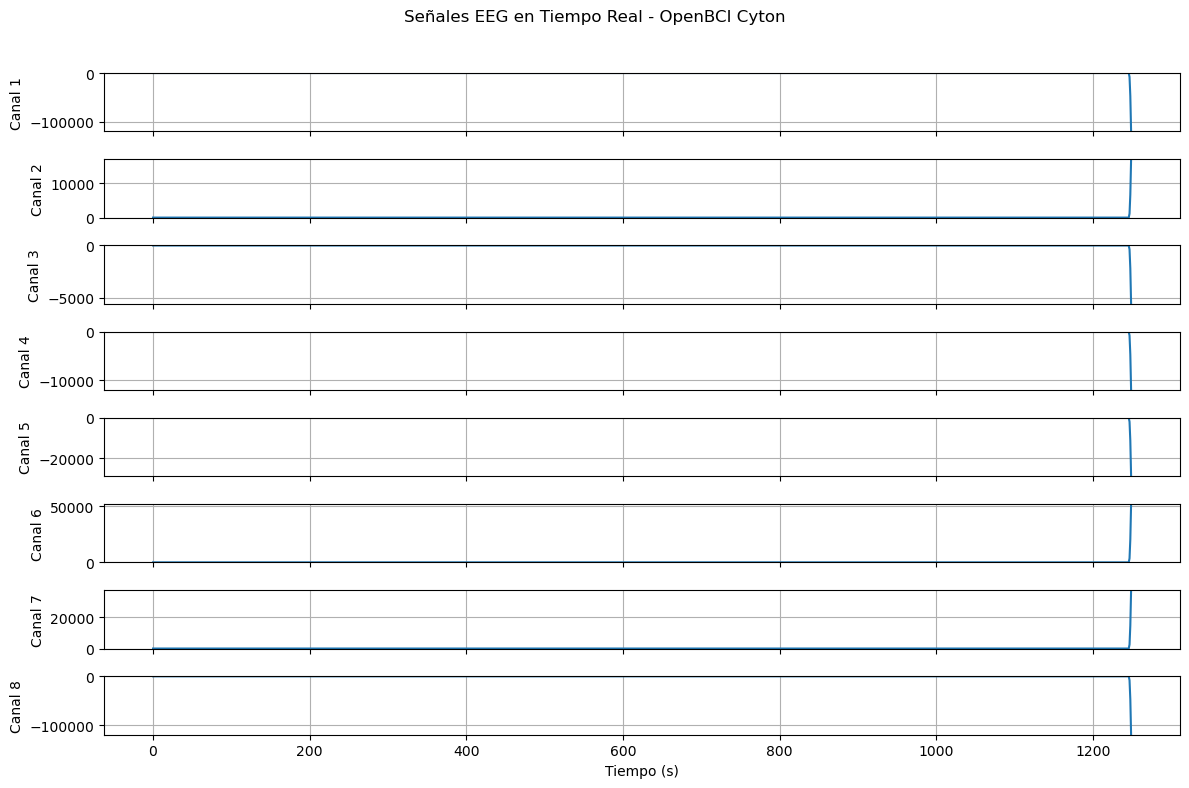

In [28]:
# Importa el módulo para el manejo de tiempos y pausas
import time
# Importa la biblioteca para computación numérica
import numpy as np
# Importa la biblioteca para creación de gráficos
import matplotlib.pyplot as plt
# Importa la funcionalidad para crear animaciones en gráficos
from matplotlib.animation import FuncAnimation
# Importa las clases necesarias para comunicarse con placas OpenBCI
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
# Importa funciones para filtrado de señales
from brainflow.data_filter import DataFilter, FilterTypes

# Define una clase para visualizar señales EEG en tiempo real
class VisualizadorEEG:
    # Constructor que inicializa el visualizador con un puerto serial específico
    def __init__(self, puerto_serial):
        # Crea un objeto para configurar los parámetros de conexión
        self.params = BrainFlowInputParams()
        # Asigna el puerto serial para la conexión con el dongle
        self.params.serial_port = puerto_serial
        # Crea una instancia de conexión con la placa Cyton
        self.board = BoardShim(BoardIds.CYTON_BOARD, self.params)
        
        # Define el intervalo de actualización del gráfico en milisegundos
        self.update_interval = 50  # Actualización cada 50ms
        # Define el tamaño de la ventana de tiempo a mostrar en segundos
        self.window_size = 5  # Ventana de 5 segundos
        # Obtiene la frecuencia de muestreo de la placa Cyton
        self.fs = BoardShim.get_sampling_rate(BoardIds.CYTON_BOARD)
        # Calcula el tamaño del buffer basado en la frecuencia y la ventana de tiempo
        self.buffer_size = int(self.window_size * self.fs)
        
        # Obtiene los índices de los canales EEG disponibles en la placa
        self.eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD)
        # Almacena el número total de canales EEG
        self.n_channels = len(self.eeg_channels)
        # Crea un buffer para almacenar los datos de cada canal
        self.data_buffer = np.zeros((self.n_channels, self.buffer_size))
        
        # Crea una figura con subgráficos para cada canal EEG
        self.fig, self.axes = plt.subplots(self.n_channels, 1, figsize=(12, 8), sharex=True)
        # Añade un título a la figura completa
        self.fig.suptitle('Señales EEG en Tiempo Real - OpenBCI Cyton')
        
        # Lista para almacenar las referencias a cada línea de los gráficos
        self.lines = []
        # Configura cada uno de los subgráficos
        for i in range(self.n_channels):
            # Crea una línea con datos inicializados a cero
            line, = self.axes[i].plot(np.zeros(self.buffer_size))
            # Etiqueta el eje Y con el número de canal
            self.axes[i].set_ylabel(f'Canal {i+1}')
            # Activa la rejilla para mejor visualización
            self.axes[i].grid(True)
            # Añade la referencia de la línea a la lista
            self.lines.append(line)
        
        # Etiqueta el eje X del último subgráfico
        self.axes[-1].set_xlabel('Tiempo (s)')
        # Crea un vector de tiempo para el eje X
        self.tiempo = np.linspace(0, self.window_size, self.buffer_size)
    
    # Método para iniciar la adquisición y visualización de datos
    def iniciar_adquisicion(self):
        # Prepara la sesión de comunicación con la placa
        self.board.prepare_session()
        # Inicia la transmisión de datos desde la placa
        self.board.start_stream()
        
        # Configura la animación que actualizará el gráfico
        self.ani = FuncAnimation(
            self.fig, self.actualizar_grafico, 
            interval=self.update_interval, blit=True,
            cache_frame_data=False  # Desactiva el almacenamiento en caché de frames
        )
        # Ajusta el diseño para mejor visualización
        plt.tight_layout()
        # Ajusta el espacio superior para el título
        plt.subplots_adjust(top=0.9)
        # Muestra la figura interactiva
        plt.show()
    
    # Método para detener la adquisición de datos
    def detener_adquisicion(self):
        # Detiene la transmisión de datos
        self.board.stop_stream()
        # Libera los recursos de la sesión
        self.board.release_session()
    
    # Método que se llama en cada actualización del gráfico
    def actualizar_grafico(self, frame):
        # Obtiene los datos más recientes de la placa
        data = self.board.get_current_board_data(self.buffer_size)
        
        # Si no hay datos disponibles, retorna sin cambios
        if data.size == 0:
            return self.lines
        
        # Procesa cada canal EEG
        for i, ch in enumerate(self.eeg_channels):
            # Aplica un filtro pasa-banda para mejorar la visualización
            DataFilter.perform_bandpass(
                data[ch], self.fs, 1.0, 50.0, 4,
                FilterTypes.BUTTERWORTH.value, 0
            )
            
            # Actualiza el buffer con los nuevos datos
            if data[ch].size >= self.buffer_size:
                # Si hay suficientes datos, usa los más recientes
                self.data_buffer[i] = data[ch][-self.buffer_size:]
            else:
                # Si hay menos datos que el buffer, los coloca al final
                self.data_buffer[i, -data[ch].size:] = data[ch]
            
            # Actualiza los datos de la línea en el gráfico
            self.lines[i].set_ydata(self.data_buffer[i])
            
            # Ajusta automáticamente los límites del eje Y
            self.axes[i].set_ylim(
                np.min(self.data_buffer[i]) - 10,
                np.max(self.data_buffer[i]) + 10
            )
        
        # Retorna las líneas actualizadas para la animación
        return self.lines
    
    # Método principal que ejecuta todo el proceso
    def ejecutar(self):
        try:
            # Inicia la adquisición y visualización
            self.iniciar_adquisicion()
        except KeyboardInterrupt:
            # Maneja la interrupción del usuario (Ctrl+C)
            pass
        finally:
            # Asegura que los recursos se liberen correctamente
            self.detener_adquisicion()

# Crea una instancia del visualizador con el puerto COM3
visualizador = VisualizadorEEG("COM3")
# Ejecuta el visualizador
visualizador.ejecutar()
# Cierra la figura al finalizar

## 7. Resolución de Problemas Comunes

### 7.1 No se detecta el puerto COM

- Verifique que el dongle esté correctamente conectado
- Reinstale los drivers del dongle desde la página oficial de OpenBCI
- Pruebe con otro cable USB o puerto USB

### 7.2 Error de conexión con la placa

- Compruebe que la placa esté encendida (LED de alimentación)
- Verifique la carga de las baterías
- Asegúrese de que el dongle y la placa estén correctamente emparejados

### 7.3 Problemas con la calidad de señal

- Verifique la correcta conexión de los electrodos
- Utilice gel conductor para mejorar la conductividad
- Compruebe la impedancia de los electrodos (debe ser <10kΩ idealmente)

## 8. Recursos Adicionales

### 8.1 Documentación Oficial

- [OpenBCI Cyton Documentation](https://docs.openbci.com/Cyton/CytonLanding/)
- [Brainflow Documentation](https://brainflow.readthedocs.io/)

### 8.2 Herramientas Complementarias

- [OpenBCI GUI](https://github.com/OpenBCI/OpenBCI_GUI): Interfaz gráfica para visualización y configuración
- [MNE-Python](https://mne.tools/stable/index.html): Biblioteca para análisis avanzado de señales neurofisiológicas